# GRO620 - Problématique

Voici le fichier de départ de la problématique. Si tout a été installé correctement, vous devriez voir apparaître la première image (DSCF8010.jpeg).

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

print("GRO620 - Problématique")
print("OpenCV version", cv.__version__)

%matplotlib inline

GRO620 - Problématique
OpenCV version 4.12.0


In [2]:
images_fn = os.listdir("photos_prob/")
images_fn.sort()
print("%i photo(s) à traiter" % (len(images_fn)))
if len(images_fn) == 0:
    print(
        "ERREUR! Vérifiez que vous avez bien un dossier photos_prob au même endroit que ce calepin."
    )

images = []

for f in images_fn:
    img_path = os.path.join("photos_prob/", f)
    img = cv.imread(img_path)
    assert img is not None
    images.append(img)


9 photo(s) à traiter


In [3]:
# 1. Parametres de la camera

FOCAL_LENGTH = 23.0e-3  # m
IMG_WIDTH = 640  # px
IMG_HEIGHT = 427  # px
SENSOR_WIDTH = 23.4e-3  # m
SENSOR_HEIGHT = 15.6e-3  # m

# Calcul des parametres intrinseques

fx = FOCAL_LENGTH * (IMG_WIDTH / SENSOR_WIDTH)
fy = FOCAL_LENGTH * (IMG_HEIGHT / SENSOR_HEIGHT)
cx = IMG_WIDTH / 2.0
cy = IMG_HEIGHT / 2.0
skew = 0.0

K = np.array(
    [
        [fx, skew, cx],
        [0, fy, cy],
        [0, 0, 1],
    ],
    dtype=np.float32,
)

print(f"Matrice intrinseque K:\n{K}")


Matrice intrinseque K:
[[629.0598   0.     320.    ]
 [  0.     629.5513 213.5   ]
 [  0.       0.       1.    ]]


In [4]:
# 2. Matrice de transformation extrinseque w_T_c (repere {C} au repere {0})

w_T_c = np.array(
    [
        [1, 0, 0, 0.500],
        [0, -1, 0, 0.200],
        [0, 0, -1, 0.282],
        [0, 0, 0, 1],
    ],
    dtype=np.float32,
)

print(f"Matrice extrinseque w_T_c (Camera -> World):\n{w_T_c}\n")

# Calcul de Z_c
X_0 = 0  # m
Y_0 = 0  # m
Z_0 = 0  # m
z_conveyor = w_T_c[2, 3] + w_T_c[2, 0] * X_0 + w_T_c[2, 1] * Y_0 + w_T_c[2, 3] * Z_0  # m

print(f"Z_c: {z_conveyor} m")

Matrice extrinseque w_T_c (Camera -> World):
[[ 1.     0.     0.     0.5  ]
 [ 0.    -1.     0.     0.2  ]
 [ 0.     0.    -1.     0.282]
 [ 0.     0.     0.     1.   ]]

Z_c: 0.28200000524520874 m


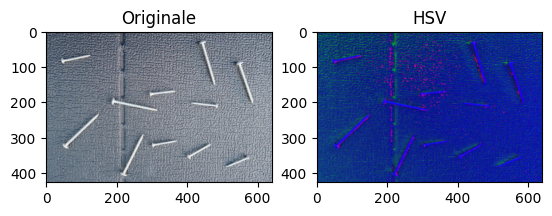

In [5]:
# Traitement de l'image

# NOTE: The image read into memory by OpenCV is assumed to be BGR

output_image = cv.cvtColor(images[8], cv.COLOR_BGR2HSV)

plt.subplot(121)
plt.imshow(images[8])
plt.title("Originale")

plt.subplot(122)
plt.imshow(output_image)
plt.title("HSV")

plt.show()

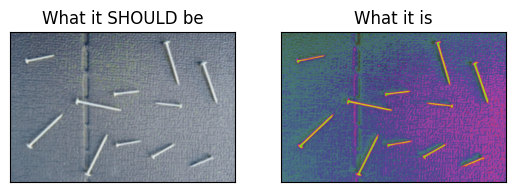

In [6]:
# Denoise
output_image = cv.GaussianBlur(output_image, (7, 7), 0.0)

# Sharpen, but with a twist
rgb = cv.cvtColor(output_image, cv.COLOR_HSV2BGR)
output_image = cv.cvtColor(output_image, cv.COLOR_HSV2BGR)  # That's legal
output_image = cv.cvtColor(output_image, cv.COLOR_HSV2RGB)  # That's either illegal, or voodoo magic.

plt.subplot(1, 2, 1), plt.imshow(rgb)
plt.title("What it SHOULD be"), plt.xticks([]), plt.yticks([])
plt.subplot(1, 2, 2), plt.imshow(output_image)
plt.title("What it is"), plt.xticks([]), plt.yticks([])

plt.show()


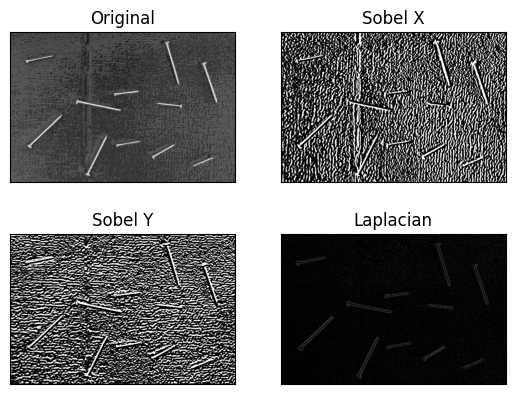

In [7]:
# Image gradient

gray = cv.cvtColor(output_image, cv.COLOR_RGB2GRAY)
laplacian = cv.Laplacian(gray, cv.CV_8U)
sobelx = cv.Sobel(gray, cv.CV_8U, 1, 0, ksize=5)
sobely = cv.Sobel(gray, cv.CV_8U, 0, 1, ksize=5)

plt.subplot(2, 2, 1), plt.imshow(gray, cmap="gray")
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(sobelx, cmap="gray")
plt.title("Sobel X"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(sobely, cmap="gray")
plt.title("Sobel Y"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(laplacian, cmap="gray")
plt.title("Laplacian"), plt.xticks([]), plt.yticks([])

plt.show()

# Conclusion: on oublie les gradients d'image, car ils sont
# un peu trop capricieux à mon goût.

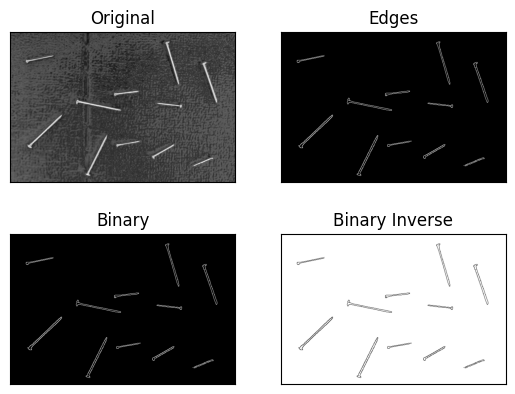

In [8]:
# Edge detection

gray = cv.cvtColor(output_image, cv.COLOR_RGB2GRAY)
edges = cv.Canny(gray, 100, 200)

# Thresholding

ret, binary = cv.threshold(edges, 100, 200, cv.THRESH_BINARY)
ret, binary_inv = cv.threshold(edges, 100, 200, cv.THRESH_BINARY_INV)

plt.subplot(2, 2, 1), plt.imshow(gray, cmap="gray")
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 2), plt.imshow(edges, cmap="gray")
plt.title("Edges"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 3), plt.imshow(binary, cmap="gray")
plt.title("Binary"), plt.xticks([]), plt.yticks([])
plt.subplot(2, 2, 4), plt.imshow(binary_inv, cmap="gray")
plt.title("Binary Inverse"), plt.xticks([]), plt.yticks([])

plt.show()

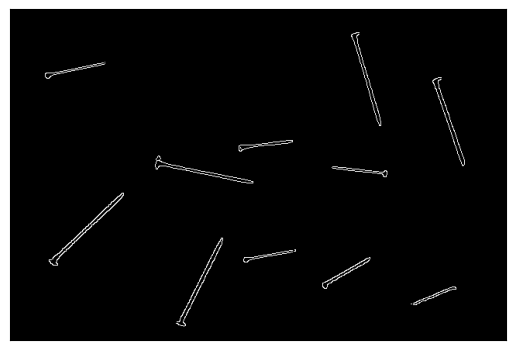

In [9]:
plt.imshow(binary, "gray")
plt.xticks([]), plt.yticks([])
plt.show()

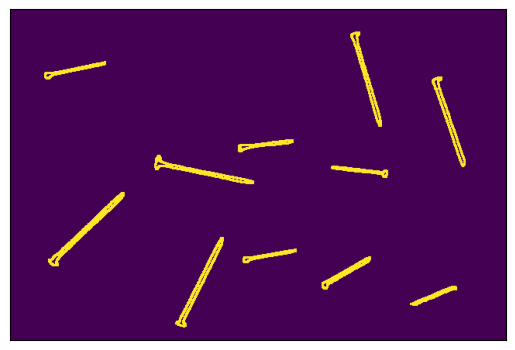

In [10]:
# Morphological dilation

kernel = np.ones((3, 3), dtype=np.uint8)

dilated = cv.dilate(binary, kernel, iterations=1)

plt.imshow(dilated)
plt.xticks([]), plt.yticks([])
plt.show()

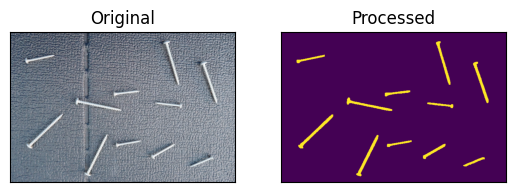

In [11]:
# Contour detection and filling

contours, _ = cv.findContours(dilated, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
filled = np.zeros_like(binary)

cv.drawContours(filled, contours, -1, 255, thickness=cv.FILLED)

plt.subplot(1, 2, 1), plt.imshow(images[8])
plt.title("Original"), plt.xticks([]), plt.yticks([])
plt.subplot(1, 2, 2), plt.imshow(filled)
plt.title("Processed"), plt.xticks([]), plt.yticks([])

plt.show()

In [12]:
# Identify, classify, and compute pose

contours, _ = cv.findContours(filled, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

results = []
screw_id: int = 0

MIN_SCREW_AREA = 100  # px
MAX_SCREW_AREA = 2000  # px
HEIGHT_THRESHOLD = 100.0  # px

# Extract caracterstics
for contour in contours:
    area = cv.contourArea(contour)
    if area < MIN_SCREW_AREA or area > MAX_SCREW_AREA:
        continue

    rect = cv.minAreaRect(contour)
    (c_u, c_v), (width, height), theta = rect

    # Draw bounding box and id
    box = cv.boxPoints(rect)
    box = np.intp(box)  # Convert box points to integer type for drawing
    cv.drawContours(images[8], [box], 0, (0, 0, 255), 2)
    cv.putText(
        images[8],
        str(screw_id),
        (int(c_u) - 5, int(c_v) - 5),
        cv.FONT_HERSHEY_SIMPLEX,
        0.7,
        (255, 0, 0),
        3,
        cv.LINE_AA,
    )

    # Standardise notation
    if width > height:
        width, height = height, width
        theta += 90

    screw_type = "courte"
    if height > HEIGHT_THRESHOLD:
        screw_type = "longue"

    if theta < 0:
        theta += 180

    # px -> mm ({C} frame)
    x_c = (c_u - cx) * z_conveyor / fx
    y_c = (c_v - cy) * z_conveyor / fy

    # {C} -> {0}
    x_0 = x_c - w_T_c[0, 3]
    y_0 = -y_c + w_T_c[1, 3]
    z_0 = 0.0

    results.append(
        {
            "id": screw_id,
            "type": screw_type,
            "X": x_0,
            "Y": y_0,
            "Z": z_0,
            "theta": theta,
            "height": height,
        }
    )
    screw_id += 1

  id  Type      X (m)    Y (m)    Z (m)    theta (deg)    height
----  ------  -------  -------  -------  -------------  --------
   0  courte   -0.399    0.130    0.000         68.587    64.255
   1  courte   -0.449    0.143    0.000         60.593    74.523
   2  courte   -0.493    0.153    0.000         81.180    70.791
   3  longue   -0.533    0.138    0.000         26.565   128.350
   4  longue   -0.598    0.168    0.000         47.203   133.626
   5  courte   -0.442    0.202    0.000         94.538    73.641
   6  longue   -0.531    0.203    0.000         98.785   130.550
   7  courte   -0.496    0.217    0.000         84.193    72.153
   8  longue   -0.390    0.230    0.000        164.197   120.875
   9  courte   -0.606    0.260    0.000         79.563    81.497
  10  longue   -0.438    0.255    0.000        166.088   126.596


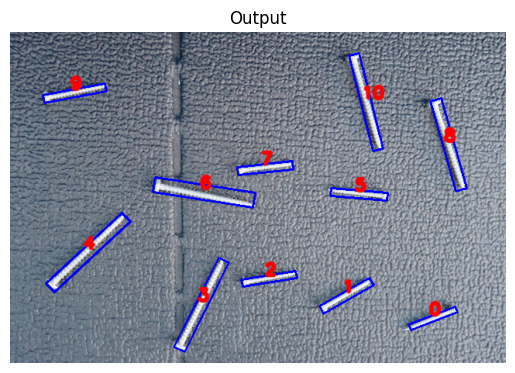

In [13]:
# Print results

import tabulate

print(
    tabulate.tabulate(
        [
            [
                screw["id"],
                screw["type"],
                screw["X"],
                screw["Y"],
                screw["Z"],
                screw["theta"],
                screw["height"],
            ]
            for screw in results
        ],
        headers=[
            "id",
            "Type",
            "X (m)",
            "Y (m)",
            "Z (m)",
            "theta (deg)",
            "height",
        ],
        floatfmt=".3f",
    )
)

plt.figure()
plt.imshow(images[8])
plt.title("Output")
plt.axis("off")
plt.show()